<a href="https://colab.research.google.com/github/maroonOcat/height/blob/main/height_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Заметки:
- Брать 3 точки (min и по точке справа и слева от нее)
- Определять, входит человек или выходит по крутизне спуска
- Нужна ли инверсия пика? (как лучше: учитывать вход/выход в измерениях или нет)
- **Использовать KNN (метод ближайших соседей)**
  - **Расчет вероятности принадлежности измерения к классу**
- **Использовать МНК**
  - **Найти центроиды классов (для каждого человека свой центроид)**
  - **Расчет квадрата расстояния от измерения до каждого центроида**
- Время добавить в самом конце после рассчета вероятностей

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

Чтение данных из Excel-таблицы.

- df_MAP_height_all - весь датасет.

- df_MAP_height_max - только максимальные значения на вход/выход.

- df_MAP_height - все значения на вход/выход.

Столбцы даты и времени не несут полезной информации, поэтому они не включены в датасеты df_MAP_height_max и df_MAP_height.

In [ ]:
#read height data from excel table (PATH for Google Colab, change it to your local/web folder)
df_MAP_height_all = pd.read_excel('drive/MyDrive/Colab Notebooks/height/alexmou_1st_try.xlsx')
df_MAP_height_max = df_MAP_height_all[['IN_MAX', 'OUT_MAX']]
df_MAP_height_max = df_MAP_height_max.dropna()

df_MAP_height = df_MAP_height_all[['TIME', 'IN', 'OUT']]
df_MAP_height = df_MAP_height.dropna()

df_MAP_description = df_MAP_height_max.describe()
df_MAP_description
df_MAP_height

,TIME,IN,OUT
0,16:37:03.677041,1603.0,865
1,16:37:03.780239,1441.0,267
2,16:37:03.882419,1289.0,262
3,16:37:03.984619,1171.0,370
4,16:37:04.087819,1019.0,459
...,...,...,...
192,16:40:20.157590,328.0,323
193,16:40:20.260912,235.0,498
194,16:40:20.363099,243.0,530
195,16:40:20.466251,558.0,607


Перевод времени из Ч:М:С в "таймштампы" (секунды).

In [ ]:
def get_sec(time_str):
    #Get seconds from time
    h, m, s = time_str.split(':')
    return int(h) * 3600 + int(m) * 60 + float(s)

df_MAP_height['TIMESTAMP'] = df_MAP_height['TIME'].apply(get_sec)

df_MAP_height.drop('TIME', axis=1, inplace=True)
df_MAP_height

,IN,OUT,TIMESTAMP
0,1603.0,865,59823.677041
1,1441.0,267,59823.780239
2,1289.0,262,59823.882419
3,1171.0,370,59823.984619
4,1019.0,459,59824.087819
...,...,...,...
192,328.0,323,60020.157590
193,235.0,498,60020.260912
194,243.0,530,60020.363099
195,558.0,607,60020.466251


Сохранение полезных данных в переменные:

In [ ]:
#Standard deviation
std_MAP_in = df_MAP_description.loc['std', 'IN_MAX']
std_MAP_out = df_MAP_description.loc['std', 'OUT_MAX']
#Mean
mean_MAP_in = df_MAP_description.loc['mean', 'IN_MAX']
mean_MAP_out = df_MAP_description.loc['mean', 'OUT_MAX']

Входы и выходы на одном графике:

Text(0, 0.5, 'Height meter mark')

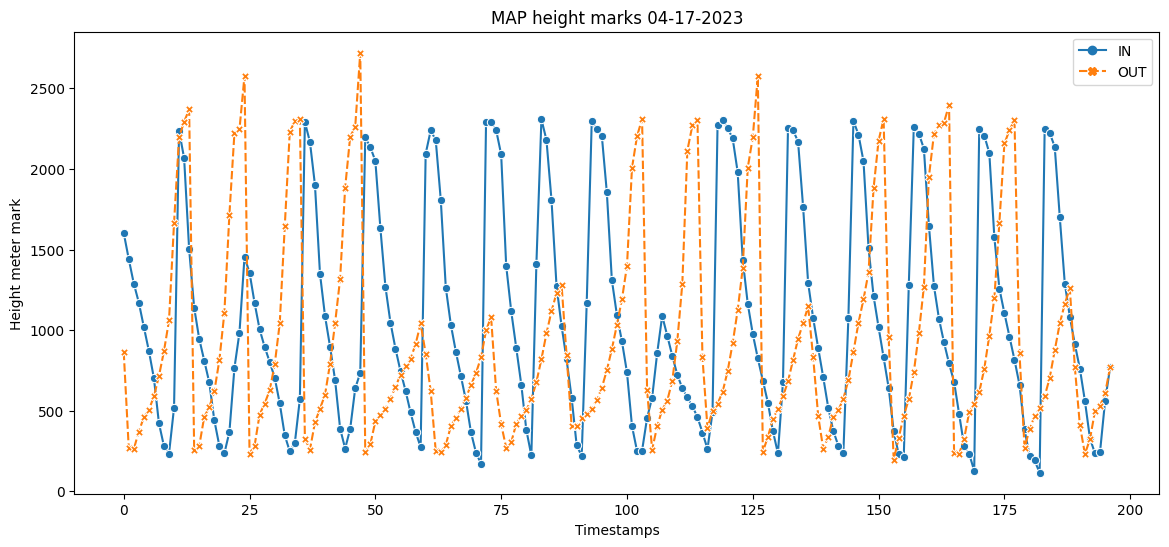

In [ ]:
plt.figure(figsize=(14,6))
plt.title("MAP height marks 04-17-2023")
sns.lineplot(data=df_MAP_height[['IN', 'OUT']], markers=True)
plt.xlabel("Timestamps")
plt.ylabel("Height meter mark")

Гистограмма распределения максимальных значений

Text(0.5, 0, 'Peak height marks')

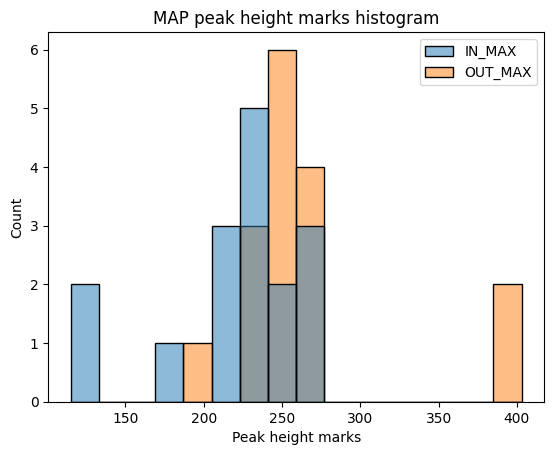

In [ ]:
list_IN = list(df_MAP_height_all['IN'])

max_list = list(df_MAP_height_max['IN_MAX'])+list(df_MAP_height_max['OUT_MAX'])
sns.histplot(df_MAP_height_max)
plt.title("MAP peak height marks histogram")
plt.xlabel("Peak height marks")

Text(0.5, 1.0, 'Boxplots of IN and OUT peaks')

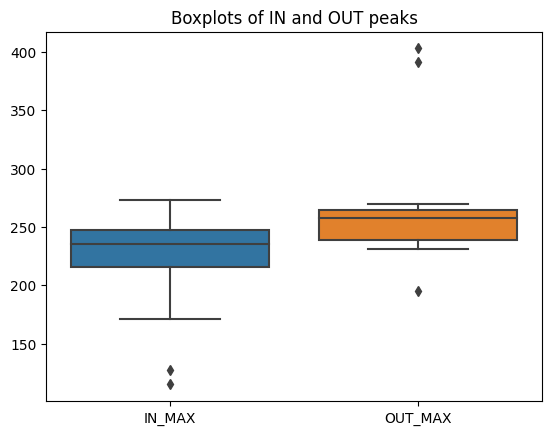

In [ ]:
sns.boxplot(df_MAP_height_max)
plt.title("Boxplots of IN and OUT peaks")

Удаление выбросов (значений, которые выходят за рамки [-3std; 3std]):

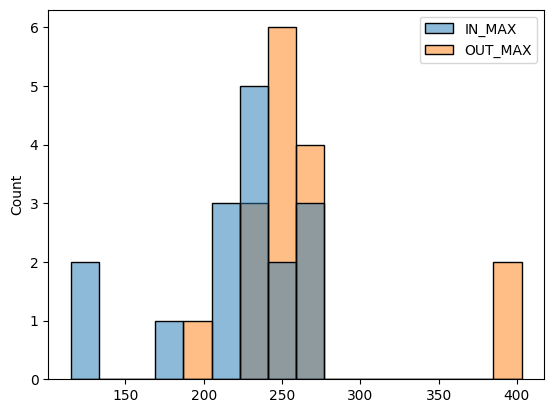

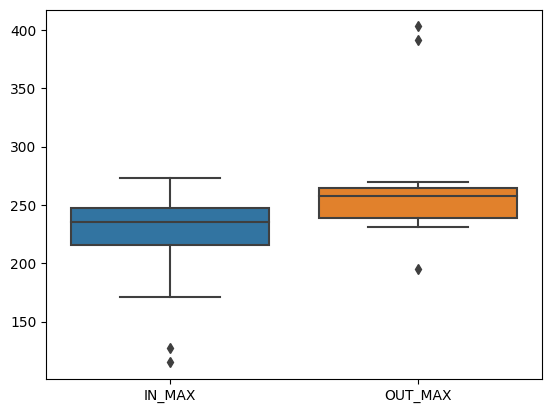

In [ ]:
from scipy.stats import zscore

df = df_MAP_height_max[(np.abs(zscore(df_MAP_height_max)) <= 3).all(axis=1)]
plot1 = sns.histplot(df)
plt.show()
plot2 = sns.boxplot(df)
plt.show()

Выбросы на boxplot -- это значения, выходящие за диапазон +-3std.

Далее следует расчет углов наклона прямых слева и справа от точки минимума. Также, в датасет добавляется вторая точка слева и вторая точка справа от минимума (их "высота" по оси Y)

In [ ]:
import math

def get_line_angle(deltaX, deltaY):
  angleInDegrees = math.atan2(deltaY, deltaX) * 180.0 / math.pi
  return angleInDegrees

def find_line_2(dot, in_or_out):
  #индекс минимума в датасете со всеми точками
  min_dot_idx = df_MAP_height.index[df_MAP_height[in_or_out] == dot].tolist()
  #предыдущая строка присваивает переменной список с одним значением,
  #удобнее будет преобразовать его в число
  min_dot_idx = min_dot_idx[0]
  #таймштамп точки минимума
  min_dot_timestamp = df_MAP_height.loc[min_dot_idx, 'TIMESTAMP']
  #значение точки, следующей за минимальным значением
  lin_dot_value = df_MAP_height.loc[min_dot_idx+1, in_or_out]
  #таймштамп точки, которая через одну от минимума
  lin_dot_timestamp = df_MAP_height.loc[min_dot_idx+1, 'TIMESTAMP']
  angle_is = get_line_angle((lin_dot_timestamp-min_dot_timestamp), lin_dot_value-dot)
  #print(dot, lin_dot_value)
  return angle_is

def find_line_1(dot, in_or_out):
  #индекс минимума в датасете со всеми точками
  min_dot_idx = df_MAP_height.index[df_MAP_height[in_or_out] == dot].tolist()
  min_dot_idx = min_dot_idx[0]
  #таймштамп точки минимума
  min_dot_timestamp = df_MAP_height.loc[min_dot_idx, 'TIMESTAMP']
  #значение точки, которая через одну от минимума
  lin_dot_value = df_MAP_height.loc[min_dot_idx-1, in_or_out]
  #таймштамп точки, которая через одну от минимума
  lin_dot_timestamp = df_MAP_height.loc[min_dot_idx-1, 'TIMESTAMP']
  angle_is = get_line_angle(abs(lin_dot_timestamp-min_dot_timestamp), abs(lin_dot_value-dot))
  #print(dot, lin_dot_value)
  return angle_is

In [ ]:
def find_distance_2(dot, in_or_out):
  #индекс минимума в датасете со всеми точками
  min_dot_idx = df_MAP_height.index[df_MAP_height[in_or_out] == dot].tolist()
  #предыдущая строка присваивает переменной список с одним значением,
  #удобнее будет преобразовать его в число
  min_dot_idx = min_dot_idx[0]
  #значение точки, следующей за минимальным значением
  lin_dot_value = df_MAP_height.loc[min_dot_idx+2, in_or_out]
  distance_is = abs(lin_dot_value-dot)
  #print(dot, lin_dot_value)
  #return distance_is
  return lin_dot_value

def find_distance_1(dot, in_or_out):
  #индекс минимума в датасете со всеми точками
  min_dot_idx = df_MAP_height.index[df_MAP_height[in_or_out] == dot].tolist()
  min_dot_idx = min_dot_idx[0]
  #значение точки, которая через одну от минимума
  lin_dot_value = df_MAP_height.loc[min_dot_idx-2, in_or_out]
  distance_is = abs(lin_dot_value-dot)
  #print(dot, lin_dot_value)
  return lin_dot_value

In [ ]:
df_max = pd.DataFrame()
df_max_out = pd.DataFrame()
df_max['MAX_VALUE'] = df_MAP_height_max['IN_MAX']
df_max['DIRECTION'] = 'IN'
df_max_out['MAX_VALUE'] = df_MAP_height_max['OUT_MAX']
df_max_out['DIRECTION'] = 'OUT'

df_max = pd.concat([df_max, df_max_out])

df_max['LEFT_ANGLE'] = df_max.apply(lambda row: find_line_1(row['MAX_VALUE'], row['DIRECTION']), axis=1)
df_max['RIGHT_ANGLE'] = df_max.apply(lambda row: find_line_2(row['MAX_VALUE'], row['DIRECTION']), axis=1)
df_max['SECOND_LEFT_DOT'] = df_max.apply(lambda row: find_distance_1(row['MAX_VALUE'], row['DIRECTION']), axis=1)
df_max['SECOND_RIGHT_DOT'] = df_max.apply(lambda row: find_distance_2(row['MAX_VALUE'], row['DIRECTION']), axis=1)

df_max['CLASS'] = 2

df_max.head(10)

,MAX_VALUE,DIRECTION,LEFT_ANGLE,RIGHT_ANGLE,SECOND_LEFT_DOT,SECOND_RIGHT_DOT,CLASS
0,234.0,IN,89.868568,89.979360,422.0,2237.0,2
1,235.0,IN,89.874145,89.955555,441.0,765.0,2
2,247.0,IN,89.940787,89.887469,546.0,571.0,2
3,265.0,IN,89.952730,89.951546,690.0,638.0,2
4,273.0,IN,89.937713,89.998324,489.0,2239.0,2
5,171.0,IN,89.913044,89.998564,366.0,2289.0,2
6,222.0,IN,89.963109,89.995021,662.0,2308.0,2
7,217.0,IN,89.915452,89.993830,581.0,2295.0,2
8,250.0,IN,89.961595,87.044472,738.0,455.0,2
9,262.0,IN,89.942528,89.974322,461.0,2271.0,2


Создание данных для среднего роста из данных для высокого роста:

- Прибавляется 100 к значению
- Угол уменьшается (составляет 99,9%)
- Правая и левая точки выше на 0,5%

In [ ]:
df_std = df_max.copy()
df_std['MAX_VALUE'] = df_std['MAX_VALUE'] + 100
df_std['LEFT_ANGLE'] = df_std['LEFT_ANGLE'] * 0.999
df_std['RIGHT_ANGLE'] = df_std['RIGHT_ANGLE'] * 0.999
df_std['SECOND_LEFT_DOT'] = df_std['SECOND_LEFT_DOT'] * 1.005
df_std['SECOND_RIGHT_DOT'] = df_std['SECOND_RIGHT_DOT'] * 1.005
df_std['CLASS'] = 1
df_std.head()

,MAX_VALUE,DIRECTION,LEFT_ANGLE,RIGHT_ANGLE,SECOND_LEFT_DOT,SECOND_RIGHT_DOT,CLASS
0,334.0,IN,89.778699,89.889381,424.110,2248.185,1
1,335.0,IN,89.784270,89.865600,443.205,768.825,1
2,347.0,IN,89.850846,89.797582,548.730,573.855,1
3,365.0,IN,89.862777,89.861595,693.450,641.190,1
4,373.0,IN,89.847775,89.908326,491.445,2250.195,1


Создание данных для низкого роста из данных для высокого роста:

- Прибавляется 200 к значению
- Угол уменьшается (составляет 99,7%)
- Правая и левая точки выше на 5%

In [ ]:
df_min = df_max.copy()
df_min['MAX_VALUE'] = df_min['MAX_VALUE'] + 200
df_min['LEFT_ANGLE'] = df_min['LEFT_ANGLE'] * 0.997
df_min['RIGHT_ANGLE'] = df_min['RIGHT_ANGLE'] * 0.997
df_min['SECOND_LEFT_DOT'] = df_min['SECOND_LEFT_DOT'] * 1.05
df_min['SECOND_RIGHT_DOT'] = df_min['SECOND_RIGHT_DOT'] * 1.05
df_min['CLASS'] = 0
df_min.head()

,MAX_VALUE,DIRECTION,LEFT_ANGLE,RIGHT_ANGLE,SECOND_LEFT_DOT,SECOND_RIGHT_DOT,CLASS
0,434.0,IN,89.598962,89.709422,443.10,2348.85,0
1,435.0,IN,89.604522,89.685689,463.05,803.25,0
2,447.0,IN,89.670964,89.617807,573.30,599.55,0
3,465.0,IN,89.682872,89.681691,724.50,669.90,0
4,473.0,IN,89.667900,89.728329,513.45,2350.95,0


Объединение трех датасетов (для высокого, среднего и низкого роста) в один:

In [ ]:
df_with_angles = pd.concat([df_max, df_std, df_min]).rename(columns={"MAX_VALUE": "MIN_VALUE"})
df_with_angles

,MIN_VALUE,DIRECTION,LEFT_ANGLE,RIGHT_ANGLE,SECOND_LEFT_DOT,SECOND_RIGHT_DOT,CLASS
0,234.0,IN,89.868568,89.979360,422.00,2237.00,2
1,235.0,IN,89.874145,89.955555,441.00,765.00,2
2,247.0,IN,89.940787,89.887469,546.00,571.00,2
3,265.0,IN,89.952730,89.951546,690.00,638.00,2
4,273.0,IN,89.937713,89.998324,489.00,2239.00,2
...,...,...,...,...,...,...,...
11,463.0,OUT,89.701247,89.652174,872.55,485.10,0
12,395.0,OUT,89.722320,89.686929,2425.50,492.45,0
13,432.0,OUT,88.896042,89.667240,2517.90,514.50,0
14,469.0,OUT,89.720056,89.679197,2420.25,490.35,0


In [ ]:
from sklearn.model_selection import train_test_split

X_train_angle, X_test_angle, y_train_angle, y_test_angle = train_test_split(df_with_angles[['MIN_VALUE', 'LEFT_ANGLE',
                                                                    'RIGHT_ANGLE', 'SECOND_LEFT_DOT', 'SECOND_RIGHT_DOT']],
                                                    df_with_angles[['CLASS']],
                                                    test_size=0.2, random_state=42)

X_train_angle.head()

from sklearn.neighbors import KNeighborsRegressor

knn_model_angle = KNeighborsRegressor(n_neighbors=10)
#knn_model.fit(feature_list, df_classified['class'])
knn_model_angle.fit(X_train_angle, y_train_angle)

train_preds_angle = knn_model_angle.predict(X_test_angle)
train_preds_angle = np.round(train_preds_angle).astype(int)

#Матрица ошибок

In [ ]:
from sklearn import metrics

def draw_confusion_matrix(y_test, y_pred):
  confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
  cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
  cm_display.plot()
  plt.title("Confusion matrix (Матрица ошибок)")
  plt.show()

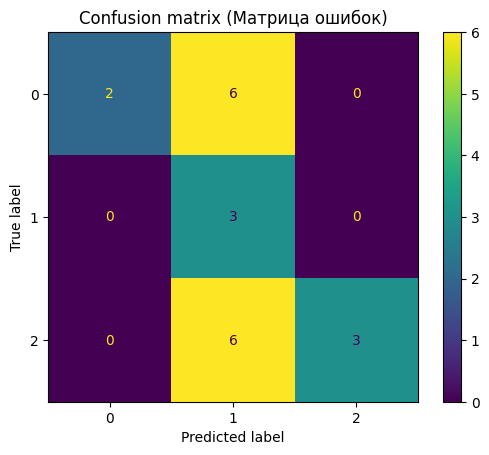

In [ ]:
draw_confusion_matrix(y_test_angle, train_preds_angle)

#Тестирование на нормальность.


Тест Шапиро-Уилка: p = 0.00014261431351769716
Критерий К-квадрата Д'Агостино: p = 0.005924787224986319
Тест Андерсона-Дарлинга (тест AD): p = AndersonResult(statistic=2.220445567495446, critical_values=array([0.523, 0.596, 0.715, 0.834, 0.992]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=243.3125, scale=54.53406008796172)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')


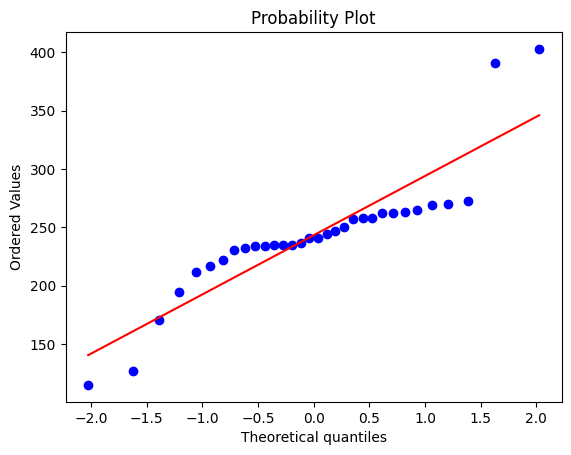

In [ ]:
import math
from scipy import stats
from scipy.stats import shapiro, anderson, normaltest
import matplotlib.pyplot as plt

#Тест Шапиро-Уилка
print(f'Тест Шапиро-Уилка: p = {shapiro(max_list).pvalue}')
#Критерий К-квадрата Д'Агостино
print(f"Критерий К-квадрата Д'Агостино: p = {normaltest(max_list).pvalue}")
#Тест Андерсона-Дарлинга (тест AD)
print(f'Тест Андерсона-Дарлинга (тест AD): p = {anderson(max_list)}')

#QQ-plot
res = stats.probplot(max_list, plot=plt)

**Тест Шапиро-Уилка**

Поскольку p-значение меньше 0.05, можно сказать, что нулевая гипотеза теста Шапиро-Уилка не верна. Это означает, что есть достаточно доказательствтого, что данные выборки НЕ получены из нормального распределения.

**Критерий К-квадрата Д'Агостино**

Интерпретируется так же, как результаты теста Шапиро-Уилка. p-значение меньше 0.05, данные выборки НЕ получены из нормального распределения.

**Тест Андерсона-Дарлинга (тест AD)**

Тестовая статистика statistic=2.22. Можно сравнить это значение с каждым критическим значением, соответствующим каждому уровню значимости, чтобы увидеть, значимы ли результаты теста. critical_values=array([0.523, 0.596, 0.715, 0.834, 0.992]). Поскольку тестовая статистика превышает все критические значения, результаты теста значимы на каждом уровне значимости; нулевая гипотеза не верна при любом уровне значимости. Таким образом, есть достаточно доказательств, что данные выборки НЕ распределены нормально.

In [ ]:
'''
list_IN = list(df_MAP_height_all['IN'])
minimum_dots = []
for height in range(len(list_IN)):
  if (list_IN[height] !=0 ):
    if ((list_IN[height-1] > list_IN[height]) and (list_IN[height+1] > list_IN[height])):
      minimum_dots.append(list_IN[height])
print(minimum_dots)
print(min(minimum_dots))
print(max(minimum_dots))
print(np.mean(minimum_dots))
'''

#Генерирование синтетических данных
Синтетические данные, генерируются после обучения модели на существующем датасете. Используется библиотека CTGAN:

In [ ]:
!pip install ctgan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.5/70.5 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 46.3 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(


,IN_MAX,OUT_MAX
count,50.000000,50.000000
mean,206.380197,322.191510
std,68.856953,105.630580
min,4.531873,181.308603
25%,188.413148,233.318943
50%,216.906497,285.517415
75%,249.927558,409.372345
max,303.792509,554.582700


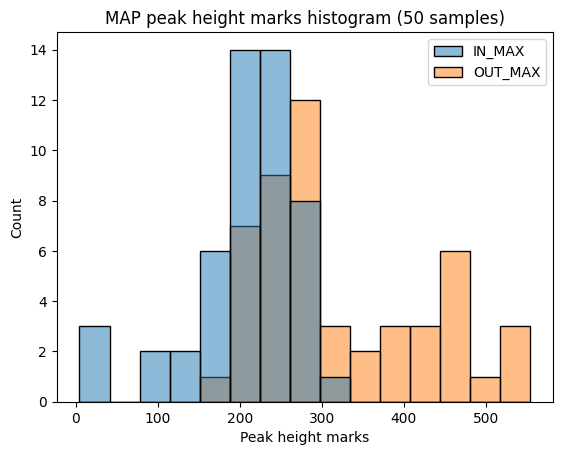

In [ ]:
from ctgan import CTGAN

ctgan = CTGAN(epochs=10)
ctgan.fit(df_MAP_height_max[['IN_MAX', 'OUT_MAX']])
# Generate the data
synthetic_height = ctgan.sample(50)

sns.histplot(synthetic_height)
plt.title("MAP peak height marks histogram (50 samples)")
plt.xlabel("Peak height marks")
synthetic_height.describe()

Создание синтетического датасета с помощью np.random.normal (нормального распределения) и нахождение "центроидов" каждого класса (в данном случае центроиды - это средние значения роста в каждом классе)

In [ ]:
class_arr = np.array([0]*100)
#centroids of 3 classes
centroids = np.array([0]*3)

#creating IN and OUT minimums for small height
small_height_in = np.random.normal(loc=mean_MAP_in+200, scale=std_MAP_in, size=50).round().astype(int)
small_height_out = np.random.normal(loc=mean_MAP_out+200, scale=std_MAP_out, size=50).round().astype(int)

class_arr.fill(0)
height = np.concatenate((small_height_in, small_height_out), axis=0)
print(f'Small height mean: {height.mean()}')
centroids[0] = height.mean()
classes = np.copy(class_arr)

#creating IN and OUT minimums for medium height
medium_height_in = np.random.normal(loc=mean_MAP_in+100, scale=std_MAP_in, size=50).round().astype(int)
medium_height_out = np.random.normal(loc=mean_MAP_out+100, scale=std_MAP_out, size=50).round().astype(int)

class_arr.fill(1)
height = np.concatenate((height, medium_height_in, medium_height_out), axis=0)
print(f'Medium height mean: {np.array([medium_height_in, medium_height_out]).mean()}')
centroids[1] = np.array([medium_height_in, medium_height_out]).mean()
classes = np.concatenate((classes, class_arr), axis=0)

#creating IN and OUT minimums for large height
large_height_in = np.random.normal(loc=mean_MAP_in, scale=std_MAP_in, size=50).round().astype(int)
large_height_out = np.random.normal(loc=mean_MAP_out, scale=std_MAP_out, size=50).round().astype(int)

class_arr.fill(2)
height = np.concatenate((height, large_height_in, large_height_out), axis=0)
print(f'Large height mean: {np.array([large_height_in, large_height_out]).mean()}')
centroids[2] = np.array([large_height_in, large_height_out]).mean()
classes = np.concatenate((classes, class_arr), axis=0)

'''
df_fake = pd.DataFrame(list(zip(medium_height_in, medium_height_out,
                                small_height_in, small_height_out,
                                large_height_in, large_height_out)),
                       columns=['medium_in', 'medium_out',
                                'small_in', 'small_out',
                                'large_in', 'large_out'])
'''

df_classified = pd.DataFrame(list(zip(height, classes)),
                       columns=['height_detector_value', 'class'])
df_classified['height_detector_value'].describe()

Small height mean: 444.08
Medium height mean: 347.8
Large height mean: 241.92


count    300.000000
mean     344.600000
std      100.024111
min      128.000000
25%      266.500000
50%      341.000000
75%      420.500000
max      617.000000
Name: height_detector_value, dtype: float64

Гистограмма распределения максимальных значений для высокого, среднего и низкого роста

In [ ]:
#sns.histplot(data=df_classified, x='height_detector_value', hue='class')

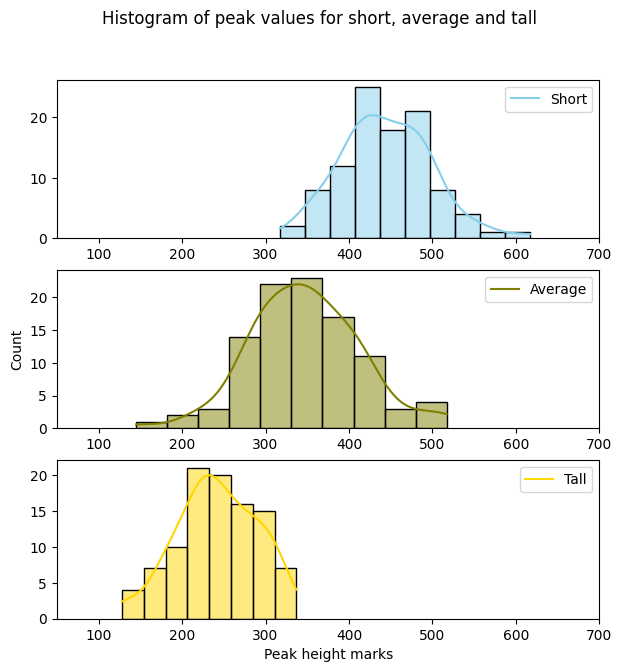

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(7, 7))

hstt = sns.histplot(data=df_classified.loc[df_classified['class'] == 0],
                    x="height_detector_value",
                    kde=True,
                    color="skyblue",
                    ax=axs[0])
hstt.set_xlim([50, 700])
axs[0].set_ylabel('')
axs[0].legend(["Short"],loc="upper right")
axs[0].set_xlabel('')

hstt = sns.histplot(data=df_classified.loc[df_classified['class'] == 1],
                    x="height_detector_value",
                    kde=True,
                    color="olive",
                    ax=axs[1])
hstt.set_xlim([50, 700])
axs[1].set_ylabel('Count')
axs[1].legend(["Average"],loc="upper right")
axs[1].set_xlabel('')

hstt = sns.histplot(data=df_classified.loc[df_classified['class'] == 2],
                    x="height_detector_value",
                    kde=True,
                    color="gold",
                    ax=axs[2])

hstt.set_xlim([50, 700])
axs[2].set_ylabel('')
axs[2].legend(["Tall"],loc="upper right")
axs[2].set_xlabel('Peak height marks')

fig.suptitle('Histogram of peak values for short, average and tall')
plt.show()

Далее построим графики boxplot для каждого роста, чтобы определить наличие выбросов в каждой выборке.

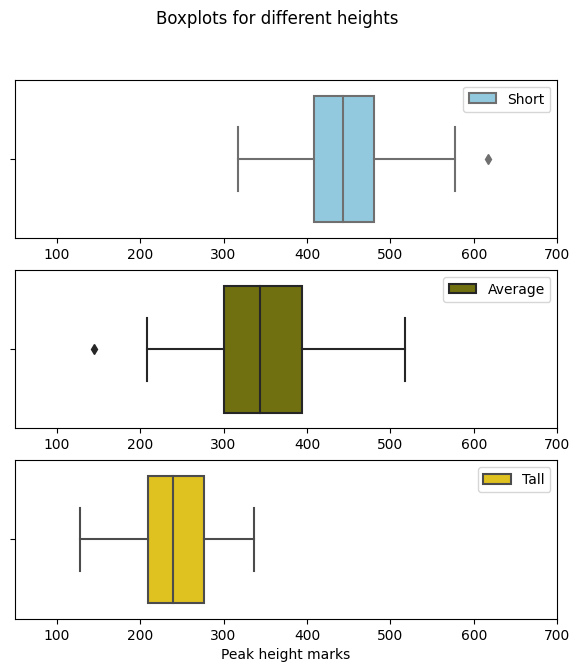

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(7, 7))

hstt = sns.boxplot(data=df_classified.loc[df_classified['class'] == 0],
                    x="height_detector_value",
                    color="skyblue",
                    ax=axs[0])
hstt.set_xlim([50, 700])
axs[0].set_ylabel('')
axs[0].legend(["Short"],loc="upper right")
axs[0].set_xlabel('')

hstt = sns.boxplot(data=df_classified.loc[df_classified['class'] == 1],
                    x="height_detector_value",
                    color="olive",
                    ax=axs[1])
hstt.set_xlim([50, 700])
axs[1].legend(["Average"],loc="upper right")
axs[1].set_xlabel('')

hstt = sns.boxplot(data=df_classified.loc[df_classified['class'] == 2],
                    x="height_detector_value",
                    color="gold",
                    ax=axs[2])

hstt.set_xlim([50, 700])
axs[2].set_ylabel('')
axs[2].legend(["Tall"],loc="upper right")
axs[2].set_xlabel('Peak height marks')

fig.suptitle('Boxplots for different heights')
plt.show()

Разделение датасета на тренировочную и тестовую выборки

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_classified[['height_detector_value']],
                                                    df_classified[['class']],
                                                    test_size=0.2, random_state=42)

X_train

,height_detector_value
232,193
59,480
6,537
185,373
173,373
...,...
188,399
71,434
106,282
270,210


In [ ]:
#feature_list = np.array(df_classified['height_detector_value'])
#feature_list = np.reshape(feature_list, (-1, 1))

feature_list = np.array(X_test)

#Классификация с помощью KNN (Sklearn)

---



In [ ]:
from sklearn.neighbors import KNeighborsRegressor
import pickle

knn_model = KNeighborsRegressor(n_neighbors=10)
#knn_model.fit(feature_list, df_classified['class'])
knn_model.fit(X_train, y_train)

start_time = datetime.now()
train_preds = knn_model.predict(X_test)
print(datetime.now() - start_time)
#distances and indices of nearest neighbours
#score = knn_model.kneighbors(X_test)


filename = 'trained_model.pcl'
pickle.dump(knn_model, open(filename, 'wb'))

df_real_pred = pd.DataFrame(list(zip(np.array(X_test), np.array(y_test), np.round(train_preds).astype(int))),
                       columns=['height', 'real', 'predicted'])
#df_real_pred

0:00:00.004055


Пример использования модели, сохраненной в файл с помощью библиотеки pickle

In [ ]:
from datetime import datetime
import time

loaded_model = pickle.load(open(filename, 'rb'))
start_time = datetime.now()
result = loaded_model.predict([[200], [340], [403]])
print(datetime.now() - start_time)
print(f'Example of prediction: {result}')

0:00:00.001780
Example of prediction: [[1.9]
 [1.1]
 [0.4]]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


Функция, которая создает матрицу ошибок. Принимает на вход реальные и предсказанные значения:

Mean squared error: 0.2
Accuracy: 0.8


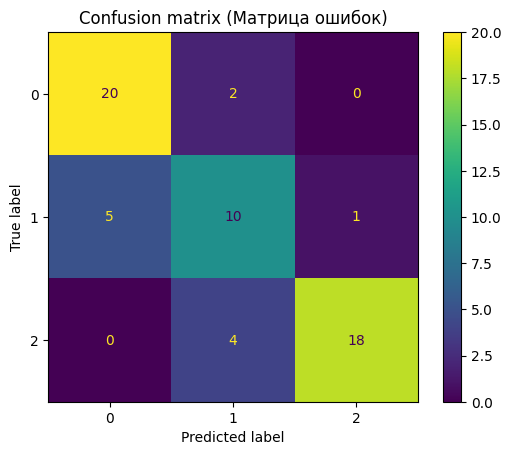

In [ ]:
from sklearn.metrics import accuracy_score, mean_squared_error
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

y_pred = np.round(train_preds).astype(int)
#find MSE: the lower MSE - the better
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
#find accuracy: the higher accuracy - the better
accuracy = accuracy_score(y_test, y_pred)
print(f'Mean squared error: {round(mse, 2)}')
print(f'Accuracy: {round(accuracy, 2)}')

draw_confusion_matrix(y_test, y_pred)


#Классификация с помощью KNN (CV2)

В случае соседства с несколькими классами выбирается класс с наибольшей вероятностью. Вероятность определяется исходя из количества ближайших соседей.
Пример: 1 класс - 3 соседа (30% вероятность), 2 класс - 1 (10%), 3 класс - 6 (60%).

In [ ]:
import cv2

knn = cv2.ml.KNearest_create()
knn.train(np.array(X_train).astype(np.float32), cv2.ml.ROW_SAMPLE,
          np.array(y_train).astype(np.float32))
start_time = datetime.now()
ret, results, neighbours, dist = knn.findNearest(np.array(X_test).astype(np.float32), 10)
print(datetime.now() - start_time)
#print("result: ", results)
#print("neighbours: ", neighbours)
#print("distance: ", dist)

classes_ind = np.array([])
for neigh in neighbours:
  values, counts = np.unique(np.array(neigh), return_counts=True)
  print(f'Nearest neighbours classes: {neigh}')
  print(f'Nearest neighbours unique classes: {values}')
  print(f'Class probability: {counts*10}, %')
  print('-'*50)

  #if more than 1 class is found - the best one will go
  if (len(values) != 1):
    #list of lists in format [[value, probability], [value, probability], ...]
    res = [[values[i], counts[i]] for i in range(len(values))]
    #list sorting. The class with the highest probability will be the 1st (0)
    res.sort(reverse=True, key = lambda x: x[1])
    #take only 1st pair, the value will be taken
    values=res[0]

  classes_ind = np.append(classes_ind, values[0])

#print(classes_ind)

0:00:00.001028
Nearest neighbours classes: [1. 1. 1. 1. 2. 2. 1. 1. 1. 1.]
Nearest neighbours unique classes: [1. 2.]
Class probability: [80 20], %
--------------------------------------------------
Nearest neighbours classes: [1. 1. 1. 2. 1. 1. 1. 2. 2. 1.]
Nearest neighbours unique classes: [1. 2.]
Class probability: [70 30], %
--------------------------------------------------
Nearest neighbours classes: [1. 1. 1. 0. 0. 1. 0. 1. 1. 0.]
Nearest neighbours unique classes: [0. 1.]
Class probability: [40 60], %
--------------------------------------------------
Nearest neighbours classes: [1. 0. 1. 1. 1. 1. 0. 0. 0. 0.]
Nearest neighbours unique classes: [0. 1.]
Class probability: [50 50], %
--------------------------------------------------
Nearest neighbours classes: [1. 1. 1. 1. 2. 1. 2. 2. 2. 2.]
Nearest neighbours unique classes: [1. 2.]
Class probability: [50 50], %
--------------------------------------------------
Nearest neighbours classes: [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
Neare

Mean squared error: 0.35
Accuracy: 0.75


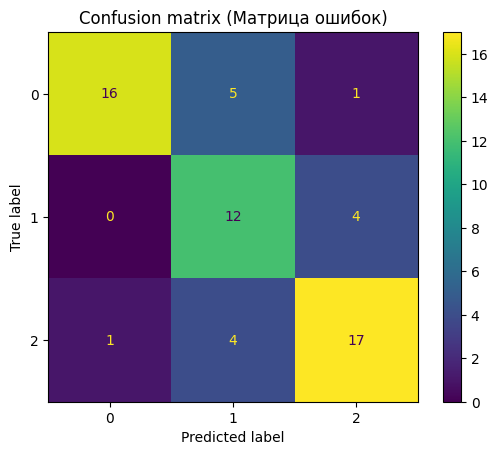

In [ ]:
mse = mean_squared_error(y_test, classes_ind)
rmse = np.sqrt(mse)
accuracy = accuracy_score(y_test, classes_ind)
print(f'Mean squared error: {round(mse, 2)}')
print(f'Accuracy: {round(accuracy, 2)}')

draw_confusion_matrix(y_test, classes_ind)

#Классификация с помощью метода наименьших квадратов
Нахождение квадратов расстояний от тестируемых величин до центроидов и выбор классов, расстояние до "центра" которых является наименьшим.

Mean squared error: 0.3333333
Accuracy: 0.7666667


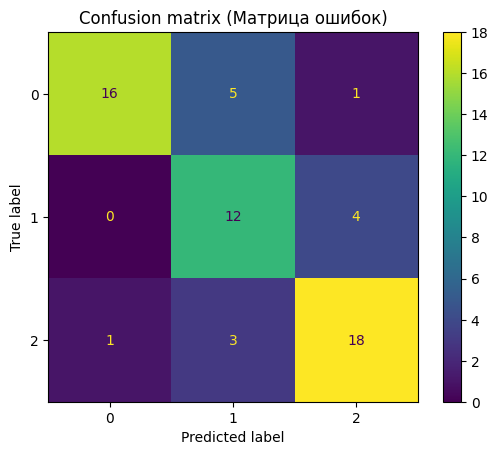

In [ ]:
difs = np.array([])
class_ind = np.array([])

for feature in feature_list:
  for center in centroids:
    #square distance to centroids
    difference = (center - feature)**2
    difs = np.append(difs, difference)

  #find classes with min distance to test_value
  class_with_min_dist = np.array(np.where(difs == difs.min()))
  #take 1st class value
  class_with_min_dist = class_with_min_dist[0][0].astype(int)
  class_ind = np.append(class_ind, class_with_min_dist)
  difs = np.array([])

mse = mean_squared_error(y_test, class_ind)
rmse = np.sqrt(mse)
accuracy = accuracy_score(y_test, class_ind)
print(f'Mean squared error: {round(mse, 7)}')
print(f'Accuracy: {round(accuracy, 7)}')

draw_confusion_matrix(y_test, class_ind)

Нахождение расстояний **(по модулю)** от тестируемых величин до центроидов и выбор классов, расстояние до "центра" которых является наименьшим.

Mean squared error: 0.3333333
Accuracy: 0.7666667


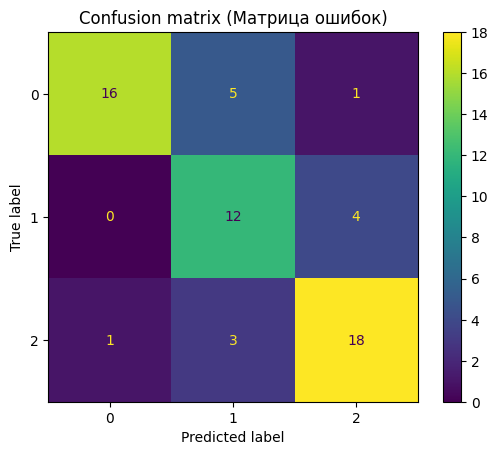

In [ ]:
abs_difs = np.array([])
abs_class_ind = np.array([])

for feature in feature_list:
  for center in centroids:
    #square distance to centroids
    abs_difference = abs(center - feature)
    abs_difs = np.append(abs_difs, abs_difference)

  #find classes with min distance to test_value
  abs_class_with_min_dist = np.array(np.where(abs_difs == abs_difs.min()))
  #take 1st class value
  abs_class_with_min_dist = abs_class_with_min_dist[0][0].astype(int)
  abs_class_ind = np.append(abs_class_ind, abs_class_with_min_dist)
  abs_difs = np.array([])

mse = mean_squared_error(y_test, abs_class_ind)
#rmse = np.sqrt(mse)
accuracy = accuracy_score(y_test, abs_class_ind)
print(f'Mean squared error: {round(mse, 7)}')
print(f'Accuracy: {round(accuracy, 7)}')

draw_confusion_matrix(y_test, abs_class_ind)

Результаты при использовании разницы по модулю и разницы квадратов расстояний одинаковы. Т.е. все равно, что использовать - модуль или квадрат.